In [8]:
import csv
import pandas as pd

df = pd.read_csv('/kaggle/input/health-ocean/Ocean_Health_Index_2018_global_scores.csv')
print(df.head)
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
df.describe(include = "all")
df.info()
df.isnull().sum()
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

<bound method NDFrame.head of      OBJECTID rgn_typ  rgn_id              rgn_nam rgn_key       are_km2  \
0           1     eez       1        Cocos Islands     CCK  4.701166e+05   
1           2     eez      10                Nauru     NRU  3.105651e+05   
2           3     eez     100  Republique du Congo     COG  3.986360e+04   
3           4     eez     101              Namibia     NAM  5.627276e+05   
4           5     eez     102         South Africa     ZAF  1.069378e+06   
..        ...     ...     ...                  ...     ...           ...   
214       218     eez      95     Falkland Islands     FLK  5.490917e+05   
215       219     eez      96         Sierra Leone     SLE  1.604526e+05   
216       220     eez      97              Liberia     LBR  2.477677e+05   
217       221     eez      98                 Togo     TGO  1.552131e+04   
218       222     eez      99                Benin     BEN  3.041927e+04   

        AO     BD     CP     CS  ...     LIV     LSP    M

In [9]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

def preprocess_numeric(df, drop_cols=None, replace_zero=True, impute_strategy='median'):
    """
    Select numeric columns, replace zeros with NaN (optional), and impute missing values.

    Parameters:
    ----------
    df : pd.DataFrame
        Input DataFrame.
    drop_cols : list, optional
        Columns to drop before processing.
    replace_zero : bool, default=True
        Whether to replace zeros with NaN.
    impute_strategy : str, default='median'
        Strategy for SimpleImputer ('mean', 'median', 'most_frequent', etc.)

    Returns:
    -------
    pd.DataFrame
        Cleaned and imputed DataFrame with only numeric columns.
    """
    # Drop unwanted columns
    if drop_cols:
        df = df.drop(columns=drop_cols, errors='ignore')

    # Select numeric columns
    numeric_df = df.select_dtypes(include=np.number)

    # Replace zeros with NaN if requested
    if replace_zero:
        numeric_df = numeric_df.replace(0, np.nan)

    print("Missing values before imputation:")
    print(numeric_df.isna().sum())

    # Impute missing values
    imputer = SimpleImputer(strategy=impute_strategy)
    df_imputed = pd.DataFrame(imputer.fit_transform(numeric_df), columns=numeric_df.columns)

    print("\nMissing values after imputation:")
    print(df_imputed.isna().sum())

    return df_imputed


drop_cols = ["OBJECTID", "rgn_id", "Shape__Area", "Shape__Length", "rgn_typ", "rgn_key", "Index_", "rgn_nam"]

df_imputed_median = preprocess_numeric(df, drop_cols=drop_cols, replace_zero=True, impute_strategy='median')




Missing values before imputation:
are_km2      0
AO           0
BD           0
CP          51
CS          70
CW           0
ECO         16
FIS          0
FP           1
HAB          1
ICO          0
LE          16
LIV         16
LSP         25
MAR        113
NP          96
SP           0
SPP          0
TR          28
trnd_sc      0
dtype: int64

Missing values after imputation:
are_km2    0
AO         0
BD         0
CP         0
CS         0
CW         0
ECO        0
FIS        0
FP         0
HAB        0
ICO        0
LE         0
LIV        0
LSP        0
MAR        0
NP         0
SP         0
SPP        0
TR         0
trnd_sc    0
dtype: int64


Shape of Original Dataset: (219, 20)
Shape after PCA: (219, 7)

Explained Variance Ratio per PC:
[0.169 0.143 0.113 0.094 0.078 0.063 0.06 ]

Cumulative Explained Variance: [0.16887096 0.31150939 0.42471145 0.5191521  0.59686838 0.6598371
 0.71985784]


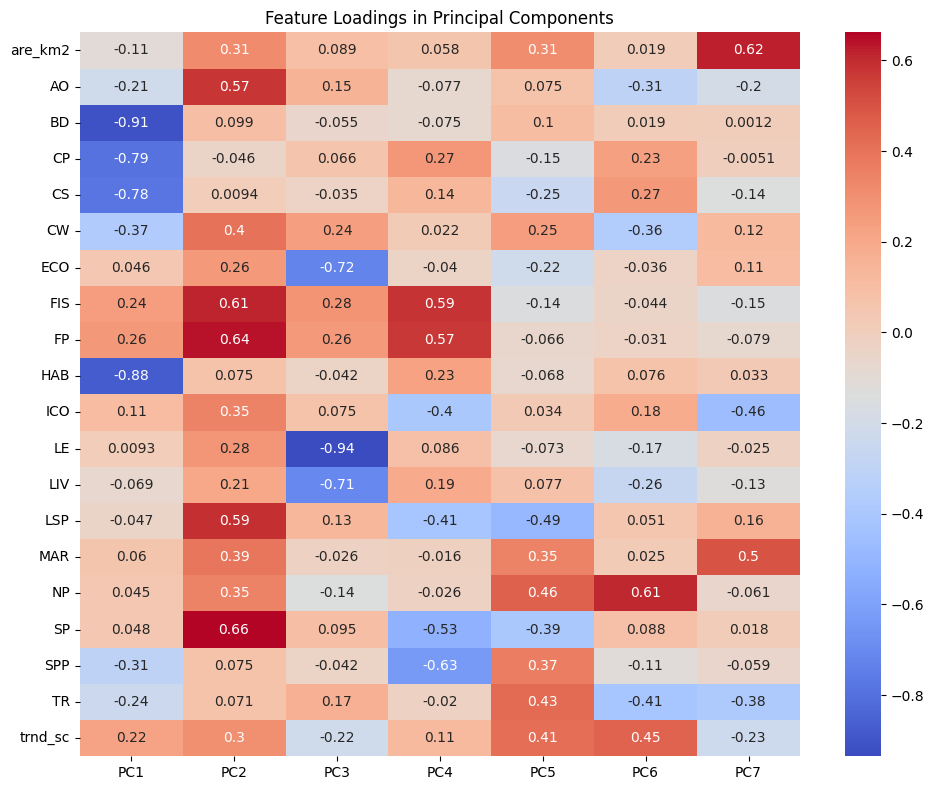

In [13]:

def run_pca(df, n_components=7, scale_data=True, show_heatmap=True):
    """
    Runs PCA on a numeric DataFrame with optional scaling and heatmap plotting.

    Parameters
    ----------
    df : pd.DataFrame
        Input numeric DataFrame.
    n_components : int, default=7
        Number of principal components to retain.
    scale_data : bool, default=True
        Whether to standardize the data before PCA.
    show_heatmap : bool, default=True
        Whether to display a heatmap of loadings.

    Returns
    -------
    dict
        Contains PCA results including:
        - 'X_scaled': scaled data (if applied)
        - 'X_pca': PCA-transformed data
        - 'pca': PCA model object
        - 'loadings': loadings matrix
        - 'explained_variance_ratio': explained variance of each PC
        - 'cumulative_explained_variance': cumulative variance
    """

    feature_names = df.columns

    # --- Standardize ---
    if scale_data:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df)
    else:
        X_scaled = df.values

    # --- Fit PCA ---
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # --- Compute loadings ---
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # --- Print summary ---
    print(f"Shape of Original Dataset: {X_scaled.shape}")
    print(f"Shape after PCA: {X_pca.shape}\n")
    print("Explained Variance Ratio per PC:")
    print(np.round(pca.explained_variance_ratio_, 3))
    print(f"\nCumulative Explained Variance: {np.cumsum(pca.explained_variance_ratio_)}")

    # --- Heatmap ---
    if show_heatmap:
        plt.figure(figsize=(10, 8))
        sns.heatmap(loadings,
                    annot=True,
                    cmap='coolwarm',
                    xticklabels=[f'PC{i+1}' for i in range(n_components)],
                    yticklabels=feature_names)
        plt.title('Feature Loadings in Principal Components')
        plt.tight_layout()
        plt.show()

    return {
        "X_scaled": X_scaled,
        "X_pca": X_pca,
        "pca": pca,
        "loadings": loadings,
        "explained_variance_ratio": pca.explained_variance_ratio_,
        "cumulative_explained_variance": np.cumsum(pca.explained_variance_ratio_)
    }
results = run_pca(df_imputed_median, n_components=7)


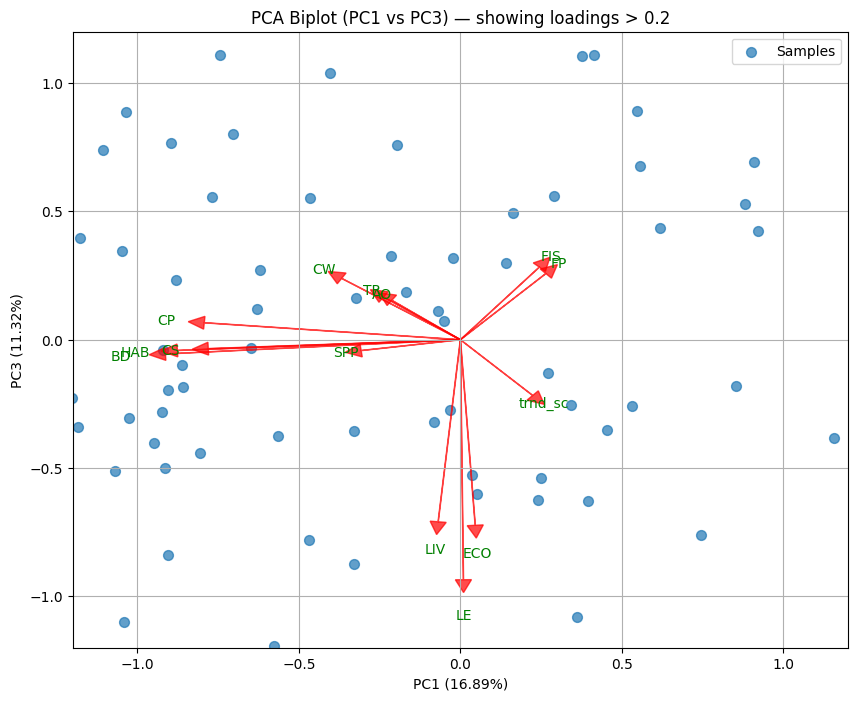

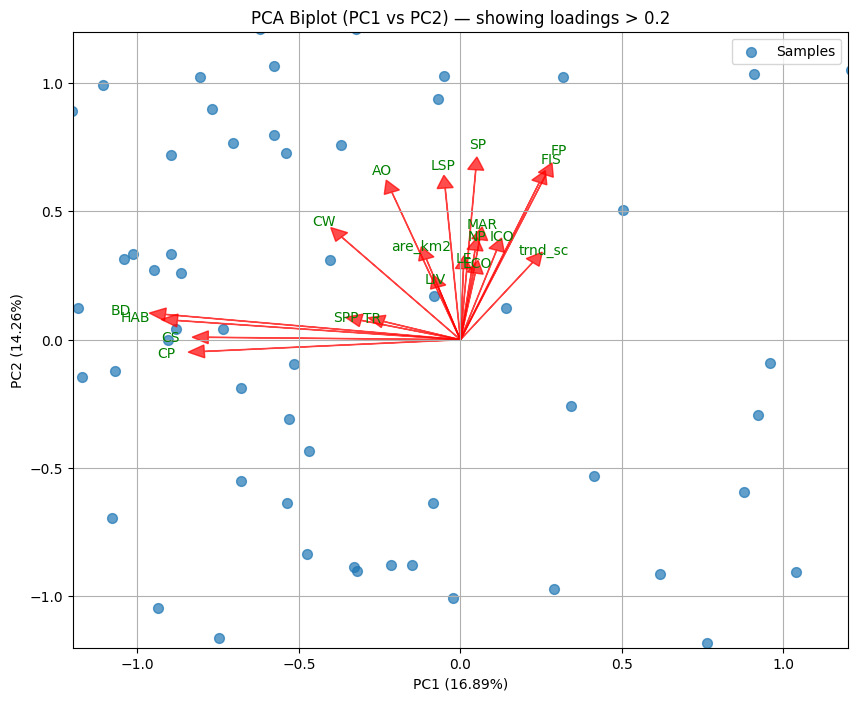

In [15]:
X_scaled = results["X_scaled"]
feature_names = df_imputed_median.columns
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

# --- Compute loadings ---
loadings = results["loadings"]

# --- Biplot function with flexible components ---
def biplot(score, loadings, feature_names, pca, pcx=1, pcy=3, loading_threshold=0.2):
    # Convert to 0-based index
    pcx -= 1
    pcy -= 1

    xs = score[:, pcx]
    ys = score[:, pcy]
    n = loadings.shape[0]

    plt.figure(figsize=(10, 8))
    plt.scatter(xs, ys, s=50, alpha=0.7, label='Samples')

    # --- Filter arrows based on loading threshold ---
    for i in range(n):
        if (abs(loadings[i, pcx]) > loading_threshold) or (abs(loadings[i, pcy]) > loading_threshold):
            plt.arrow(0, 0, loadings[i, pcx], loadings[i, pcy],
                      color='r', alpha=0.7, head_width=0.05, head_length=0.05)
            plt.text(loadings[i, pcx] * 1.15, loadings[i, pcy] * 1.15,
                     feature_names[i], color='g', ha='center', va='center')

    plt.xlabel(f"PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.2f}%)")
    plt.ylabel(f"PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.2f}%)")
    plt.title(f'PCA Biplot (PC{pcx+1} vs PC{pcy+1}) — showing loadings > {loading_threshold}')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.grid()
    plt.legend()
    plt.show()


# --- Call biplot for PC1 vs PC3 ---
biplot(X_pca, loadings, feature_names, pca, pcx=1, pcy=3)
biplot(X_pca, loadings, feature_names, pca, pcx=1, pcy=2)



In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_imputed_median, df_imputed_median["CW"], test_size=1/3, random_state=10)

print("The dimension of X_train is {}".format(X_train.shape))
print("The dimension of X_test is {}".format(X_test.shape))
X_train

The dimension of X_train is (146, 20)
The dimension of X_test is (73, 20)


,are_km2,AO,BD,CP,CS,CW,ECO,FIS,FP,HAB,ICO,LE,LIV,LSP,MAR,NP,SP,SPP,TR,trnd_sc
171,9.572936e+05,85.49,83.79,88.97,86.81,68.31,100.00,55.39,55.39,92.83,64.12,85.89,71.78,66.980,8.205,37.36,65.55,74.75,91.90,0.56
197,1.931584e+04,68.79,82.87,88.97,86.81,30.05,100.00,41.58,41.58,98.42,57.14,83.13,66.26,4.210,8.205,16.45,30.68,67.31,16.47,-0.70
206,7.557819e+05,97.04,87.03,88.97,86.81,89.26,90.04,36.17,36.17,97.19,62.20,87.90,85.75,66.735,8.205,37.36,31.10,76.87,41.66,0.37
169,2.227440e+05,61.12,73.96,45.17,45.00,43.05,100.00,48.99,48.98,68.38,62.48,84.51,69.01,51.370,0.020,50.74,56.93,79.54,3.70,0.01
43,3.429970e+05,88.19,93.21,97.89,95.63,41.77,96.85,43.67,41.93,95.32,65.46,92.06,87.26,23.510,33.840,32.27,44.48,91.10,27.20,-0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6.472321e+05,55.76,85.74,89.03,60.84,41.50,86.39,11.82,19.26,85.66,64.72,74.24,62.08,84.550,48.470,27.19,74.63,85.82,42.17,0.62
64,6.956846e+06,98.21,93.39,89.40,92.92,81.33,100.00,48.89,40.20,94.48,84.95,95.62,91.23,100.000,12.410,53.63,92.48,92.29,60.19,0.07
15,1.196055e+05,99.62,86.44,62.85,91.27,61.67,100.00,26.06,26.06,85.89,71.69,100.00,100.00,31.170,8.205,37.36,51.43,86.98,98.38,-1.17
125,1.549805e+05,98.02,84.88,57.96,61.31,62.81,100.00,77.63,76.82,86.90,89.26,100.00,100.00,83.030,3.190,17.11,86.14,82.85,45.77,0.17


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

In [23]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T


X_train shape: (146, 19)
X_test shape:  (73, 19)
Mean Squared Error (MSE): 206.36884661348532
Mean Pinball Loss (median): 6.012015521439838


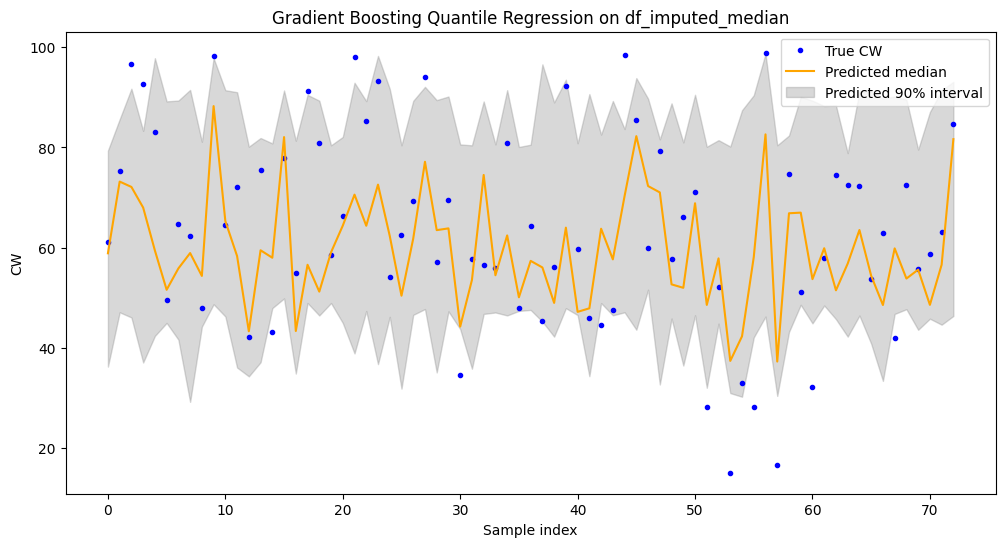

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

# --- Split data ---
# Separate features (X) and target (y)
X = df_imputed_median.drop(columns=["CW"])
y = df_imputed_median["CW"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=10
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

# --- Define common model parameters ---
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)

# --- Train quantile models ---
all_models = {}
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models[f"q {alpha:.2f}"] = gbr.fit(X_train, y_train)

# --- Train MSE (mean) model ---
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

# --- Evaluate models ---
y_pred_mean = all_models["mse"].predict(X_test)
y_pred_med = all_models["q 0.50"].predict(X_test)
y_pred_low = all_models["q 0.05"].predict(X_test)
y_pred_high = all_models["q 0.95"].predict(X_test)

# --- Compute metrics ---
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_mean))
print("Mean Pinball Loss (median):", mean_pinball_loss(y_test, y_pred_med, alpha=0.5))

# --- Plot predicted intervals (for first 100 points) ---
plt.figure(figsize=(12, 6))
idx = np.arange(len(y_test))[:100]
plt.plot(idx, y_test.iloc[:100], "b.", label="True CW")
plt.plot(idx, y_pred_med[:100], "orange", label="Predicted median")
plt.fill_between(
    idx,
    y_pred_low[:100],
    y_pred_high[:100],
    color="gray",
    alpha=0.3,
    label="Predicted 90% interval",
)
plt.xlabel("Sample index")
plt.ylabel("CW")
plt.title("Gradient Boosting Quantile Regression on df_imputed_median")
plt.legend()
plt.show()
